In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from dface import MTCNN


Читаем ключевые точки

In [2]:
mark_df = pd.read_csv('./CelebA/Anno/list_landmarks_celeba.txt', header=1, sep='\\s+')
mark_df

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
000001.jpg,165,184,244,176,196,249,194,271,266,260
000002.jpg,140,204,220,204,168,254,146,289,226,289
000003.jpg,244,104,264,105,263,121,235,134,251,140
000004.jpg,796,539,984,539,930,687,762,756,915,756
000005.jpg,273,169,328,161,298,172,283,208,323,207
...,...,...,...,...,...,...,...,...,...,...
202595.jpg,1449,201,1530,201,1491,259,1457,282,1522,286
202596.jpg,172,186,222,186,193,220,171,230,222,230
202597.jpg,81,121,113,120,101,142,81,155,116,155
202598.jpg,223,73,255,72,241,94,225,108,254,105


Смотрим произвольную картинку

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')


Image name: 146523.jpg
Landmarks: [[ 65 113]
 [111 103]
 [ 91 141]
 [ 76 168]
 [124 156]]


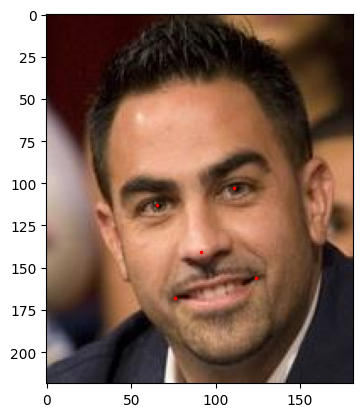

In [4]:
n = random.randint(0, len(mark_df)-1)

img_name = mark_df.index[n]
landmarks = mark_df.iloc[n]
landmarks = np.asarray(landmarks).reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks: {}'.format(landmarks))

img = Image.open(f'CelebA/Img/img_celeba/{img_name}')
show_landmarks(img, landmarks)

plt.show()


Выбираем 7000 картинок для опытов (чуть с запасом, т.к MTCNN не на всех картинках находит лица)

In [5]:
idx = random.sample(range(len(mark_df)), 7300)

По каждой выбранной картинке находим на ней лицо с помощью MTCNN, кропаем и сохраняем в папку. И ключевые точки сдвигаем и сохраняем в файл

In [6]:
mtcnn = MTCNN('cpu')

In [7]:
def get_boundingbox(box, w, h, scale=1.2):
	x1, y1, x2, y2 = box
	size = int(max(x2-x1, y2-y1) * scale)
	center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
	if size > w or size > h:
		size = int(max(x2-x1, y2-y1))
	x1 = max(int(center_x - size // 2), 0)
	y1 = max(int(center_y - size // 2), 0)
	size = min(w - x1, size)
	size = min(h - y1, size)
	return x1, y1, size


In [8]:

train_df = pd.DataFrame(columns=['lefteye_x 	lefteye_y 	righteye_x 	righteye_y 	nose_x 	nose_y 	leftmouth_x 	leftmouth_y 	rightmouth_x 	rightmouth_y'.split()])
val_df = pd.DataFrame(columns=['lefteye_x 	lefteye_y 	righteye_x 	righteye_y 	nose_x 	nose_y 	leftmouth_x 	leftmouth_y 	rightmouth_x 	rightmouth_y'.split()])

for n in idx:
    if len(train_df) == 5120 and len(val_df) == 2048:
        break

    img_name = mark_df.index[n]
    img_path = f'CelebA/Img/img_celeba/{img_name}'

    img = Image.open(img_path)
    img = np.asarray(img)
    h, w = img.shape[:2]

    landmarks = mark_df.iloc[n]
    landmarks = np.asarray(landmarks).reshape(-1, 2)

    result = mtcnn.detect([img])
    
    for res in result:
        if res is None:
            print(img_name)
            continue
            
        boxes, probs, lands = res

        dist = [np.linalg.norm(land - landmarks) for land in lands]

        box = boxes[np.argmin(dist)]
        x1, y1, size = get_boundingbox(box, w, h)

        face = Image.fromarray(img[y1:y1+size, x1:x1+size])
        
        land = landmarks - (x1, y1)

        land[land < 0] = 0
        land[land >= size] = size-1

        if len(train_df) < 5120:
            out_path = f'cropped/train/{img_name}'
            face.save(out_path)
            train_df.loc[img_name] = land.reshape(-1)
        
        elif len(val_df) < 2048:
            out_path = f'cropped/val/{img_name}'
            face.save(out_path)
            val_df.loc[img_name] = land.reshape(-1)

train_df = train_df.sort_index()
train_df.to_csv('cropped/train_landmarks.csv')

val_df = val_df.sort_index()
val_df.to_csv('cropped/val_landmarks.csv')


015536.jpg
091902.jpg
129614.jpg
120627.jpg
119541.jpg
167934.jpg
163169.jpg
177913.jpg
112324.jpg
102061.jpg
032170.jpg
112395.jpg
144928.jpg
080759.jpg
106153.jpg
193895.jpg
191737.jpg
181658.jpg
153819.jpg
053309.jpg
025780.jpg
198648.jpg
190772.jpg
095581.jpg
001441.jpg
153955.jpg
054171.jpg
068920.jpg
198118.jpg
082103.jpg
055672.jpg
048440.jpg
098926.jpg
056080.jpg
072681.jpg
043649.jpg
049400.jpg
072144.jpg
070092.jpg


Смотрим произвольную картинку из кропнутых

In [9]:
train_df = pd.read_csv('cropped/train_landmarks.csv', index_col=0)
train_df

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
000009.jpg,198,205,338,201,294,297,190,337,334,333
000010.jpg,90,118,172,107,140,162,108,199,183,186
000014.jpg,127,143,220,151,173,213,125,230,198,241
000153.jpg,90,103,159,100,128,147,93,170,166,168
000185.jpg,71,110,140,88,97,131,92,187,147,169
...,...,...,...,...,...,...,...,...,...,...
202489.jpg,143,107,187,110,177,158,115,166,166,176
202499.jpg,76,82,135,84,102,128,71,141,144,139
202531.jpg,58,59,97,53,93,85,70,104,97,97
202535.jpg,95,116,169,111,133,167,103,191,179,185


Image name: 186544.jpg
Landmarks: [[119 148]
 [239 148]
 [175 213]
 [139 267]
 [225 267]]


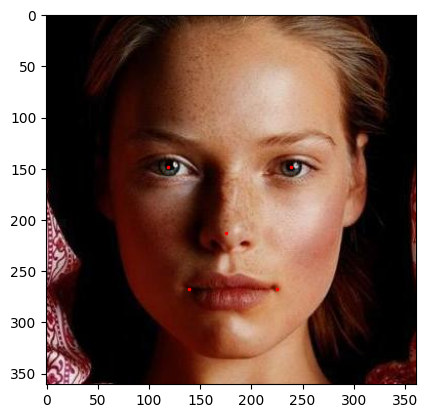

In [10]:
n = random.randint(0, len(train_df)-1)

img_name = train_df.index[n]
landmarks = train_df.iloc[n]
landmarks = np.asarray(landmarks).reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks: {}'.format(landmarks))

img = Image.open(f'cropped/train/{img_name}')
show_landmarks(img, landmarks)

plt.show()
